In [75]:
#Setup Code
import requests
URL = 'http://localhost:5000/'
#URL = 'http://68.183.114.149:5000/'

device_identifier = "user1" # replace with the device identifier you want to look at
datetime_of_session= "20190125_034930" #replace with the date and time of the session you want to look at
                            #format is: "YearMonthDay_HourMinuteSecond"
# or continue to get all the date time's associated with a particular device uuid

In [76]:
r = requests.get(URL + 'getUsers', params = None)
uuid_to_datetime_mapping = r.json()
print(uuid_to_datetime_mapping)

{'user1': ['20190113_201454', '20190113_202129', '20190113_202314', '20190113_202314', '20190113_224203', '20190116_193154', '20190116_193154', '20190116_194624', '20190116_194624', '20190116_201017', '20190116_201017', '20190125_024854', '20190125_024919', '20190125_030127', '20190125_030127', '20190125_030222', '20190125_030222', '20190125_030222', '20190125_034930', '20190125_034930', '20190125_034930'], 'user2': ['20190113_201454', '20190113_202129', '20190113_202314', '20190113_224203', '20190116_193154', '20190116_194624', '20190116_201017', '20190125_024854', '20190125_024919', '20190125_030127', '20190125_030222', '20190125_030222', '20190125_030222', '20190125_034930', '20190125_034930', '20190125_034930']}


In [77]:
assert device_identifier in uuid_to_datetime_mapping.keys(), "Please Give a valid device identifier"
assert datetime_of_session in uuid_to_datetime_mapping[device_identifier], "Please give a valid datetime"

import datetime

payload = {}
payload['deviceUUID'] = device_identifier
payload['datetime'] = datetime_of_session

r = requests.get(URL+'data', params = payload)
session_data = r.text
print(session_data)

def get_data(dtype, session_data):
    idx = 0
    if(dtype == 'flex'):
        pass
    elif(dtype == 'ecg'):
        idx = 1
    elif(dtype == 'eda'):
        idx = 2
        
    out = []
    for data_point in session_data.split('|'):
        if len(data_point) > 1:
            data_value = int(data_point.split(',')[idx])
            out.append(data_value)
    return out

def get_triggers(trigger_text_data):
    trigger_text_data = trigger_text_data.split('|')
    out = []
    start_datetime = datetime.datetime.strptime(datetime_of_session, '%Y%m%d_%H%M%S')
    for d in trigger_text_data:
        if len(d) > 1:
            split_data = d.split(',')
            reason = split_data[0]
            timestamp = datetime.datetime.strptime(split_data[1], '%Y-%m-%d %H:%M:%S.%f')
            timestamp = (timestamp - start_datetime).seconds
            legitimate = split_data[2] == ('True')
            out.append((timestamp, (reason, legitimate)))
    return out

def get_hboss(hboss_text_data):
    hboss_text_data = hboss_text_data.split('|')
    start_datetime = datetime.datetime.strptime(datetime_of_session, '%Y%m%d_%H%M%S')
    out = []
    for d in hboss_text_data:
        if len(d) > 1:
            split_data = d.split(',')
            timestamp = (datetime.datetime.utcfromtimestamp(int(float(split_data[2]))) - start_datetime).seconds
            out.append((float(split_data[0]), float(split_data[1]), timestamp))
    return out
flex_data = get_data('flex', session_data)
ecg_data = get_data('ecg', session_data)
eda_data = get_data('eda', session_data)

r = requests.get(URL+'getTriggers', params = payload)
session_triggers = get_triggers(r.text)

def plot_triggers(matplotlib_obj, triggers, sensor_data, sample_rate):
    for t in triggers:
        print(t, t[0] / (1.0/sample_rate))
        style = 'r+' if t[1][1] else 'rx'
        x = t[0]
        y = sensor_data[int(t[0] / (1.0/sample_rate))]
        matplotlib_obj.plot([x], [y], style, label=t[1][0])
        matplotlib_obj.annotate(t[1][0], (x,y))

def plot_triggers_hboss(matplotlib_obj, triggers, hboss_data, sample_rate):
    for t in triggers:
        print(t, t[0] / (1.0/sample_rate))
        style = 'r+' if t[1][1] else 'rx'
        x = t[0]
        y = sum(hboss_data)/len(hboss_data)
        plt.axvline(x=x)
        matplotlib_obj.plot([x], [y], style, label=t[1][0])
        matplotlib_obj.annotate(t[1][0], (x,y))
        
print("Triggers are: ",session_triggers)

r = requests.get(URL+'getHBOSS', params = payload)
hboss = get_hboss(r.text)
print(hboss)

||||365,451,93|367,415,93|368,687,93|371,731,92|373,524,92|373,494,92|374,470,92|374,417,92|374,524,91|374,770,91|374,601,92|374,481,92|373,492,91|372,426,91|374,407,91|373,676,91|373,712,91|373,498,91|372,463,91|371,484,91|371,448,90|370,370,90|370,647,90|368,628,90|316,469,90|272,475,90|255,523,90|261,447,89|283,16,90|319,536,92|338,863,91|251,832,91|243,788,94|241,511,97|219,955,89|216,708,87|217,1,88|218,1,85|219,340,84|219,441,87|221,452,87|221,463,87|221,340,86|222,408,86|225,474,86|224,462,86|224,421,86|224,427,85|224,421,85|224,435,85|224,555,85|224,535,84|224,470,84|224,481,84|223,487,84|223,442,84|223,541,83|223,578,83|223,504,83|223,479,83|223,474,83|223,457,83|223,488,82|223,599,82|223,553,82|223,488,82|223,491,82|223,474,82|223,468,82|223,619,82|223,630,81|223,522,81|223,517,81|223,498,81|223,468,81|223,566,81|223,713,81|220,447,80|219,301,80|221,488,80|223,511,80|223,490,80|223,724,80|223,719,80|224,534,79|224,527,79|224,498,79|225,470,79|225,592,79|225,822,79|225,643,79|

<IPython.core.display.Javascript object>


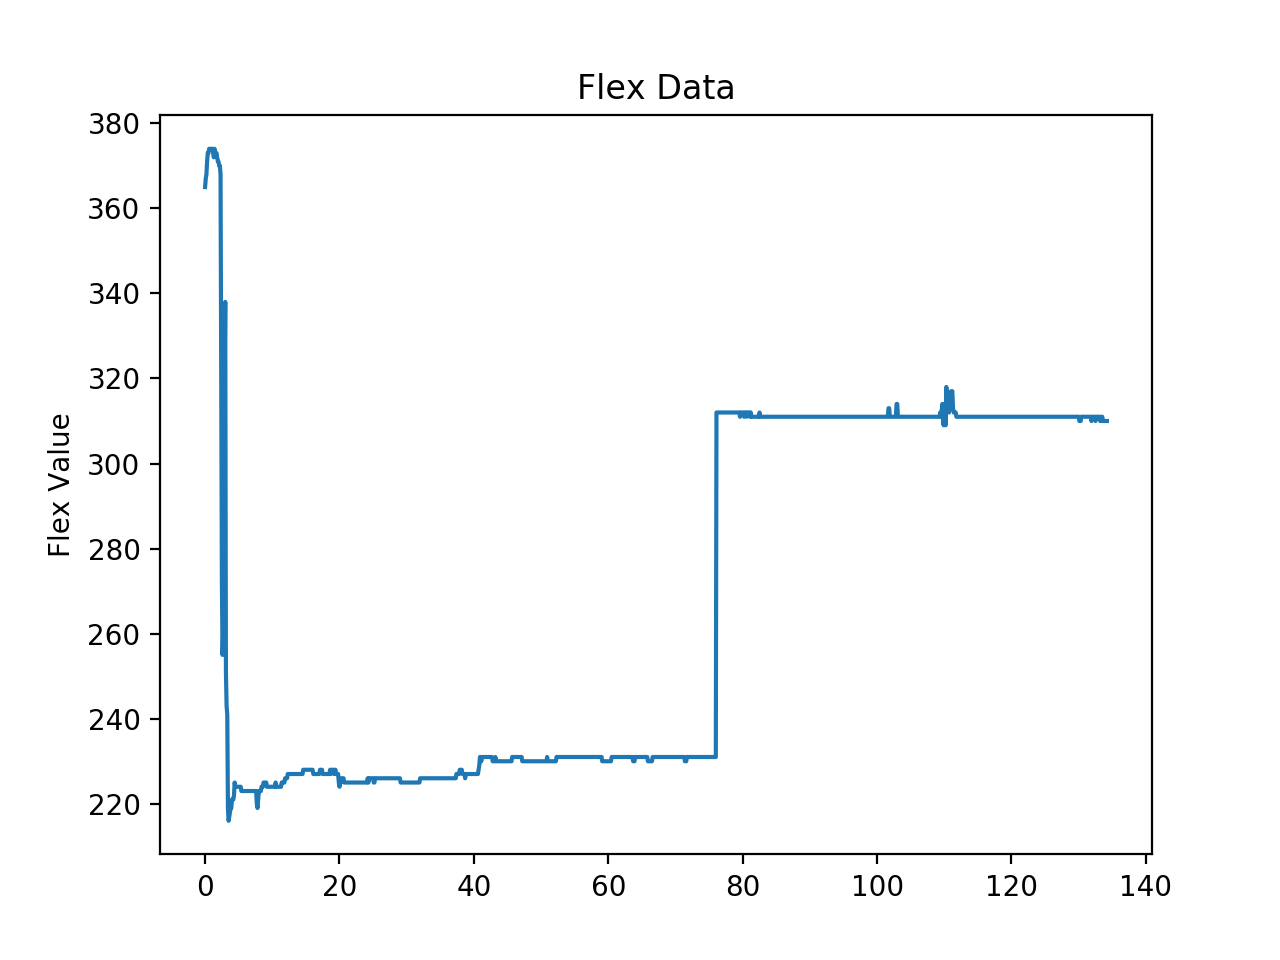

In [78]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

dormio_sample_rate = 10.0 # hz
x = [i*(1.0/dormio_sample_rate) for i in range(0, len(flex_data))]
plt.plot(x,flex_data)
plt.ylabel('Flex Value')
plt.title('Flex Data')
plt.show()

<IPython.core.display.Javascript object>


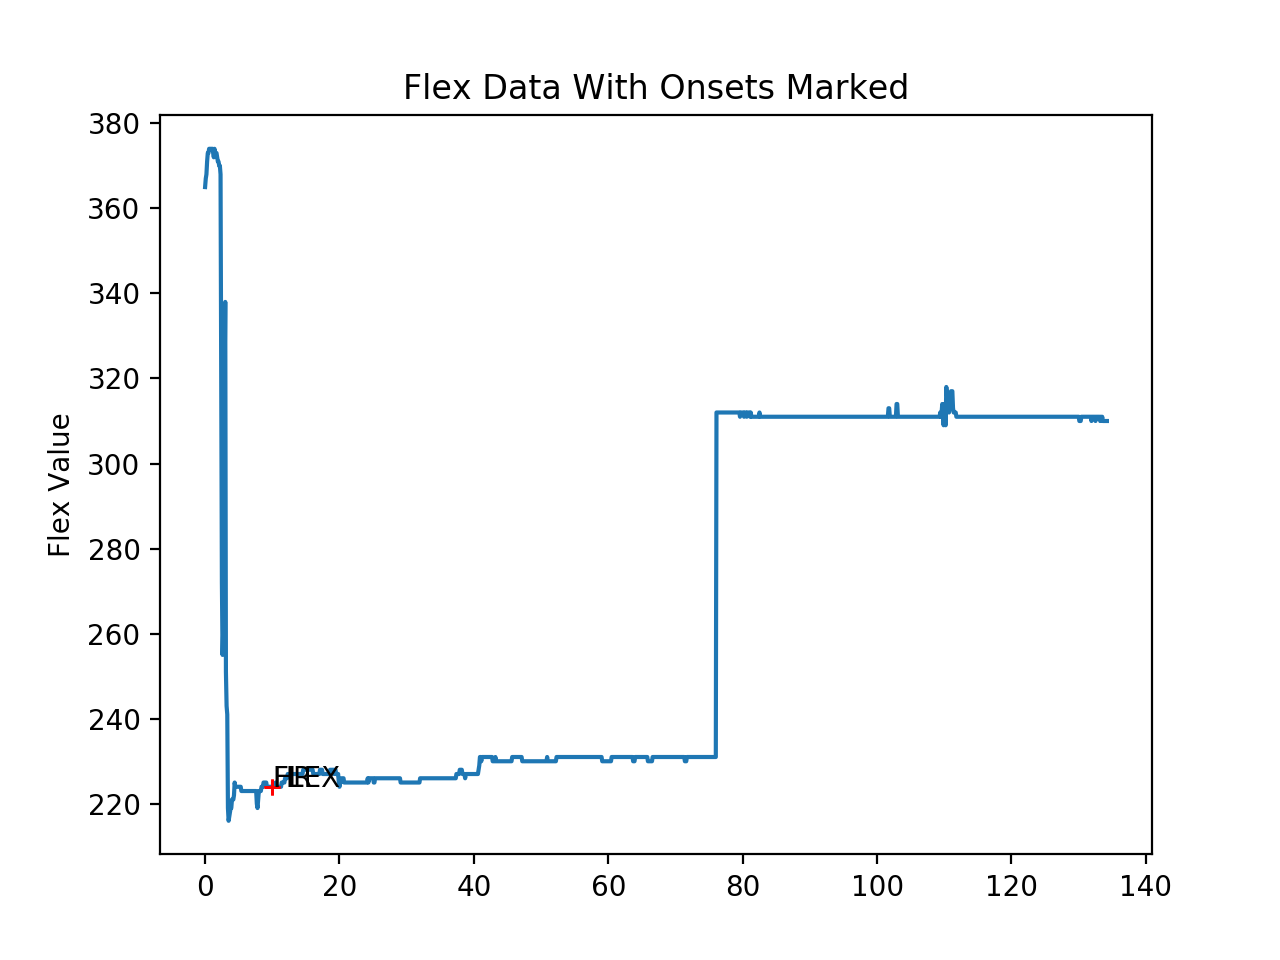

(10, ('FLEX', True)) 100.0
(10, ('HR', True)) 100.0


In [79]:
%matplotlib notebook

plt.plot(x,flex_data)
plt.ylabel('Flex Value')
plt.title('Flex Data With Onsets Marked')
plot_triggers(plt, session_triggers, flex_data, dormio_sample_rate)
plt.show()

<IPython.core.display.Javascript object>


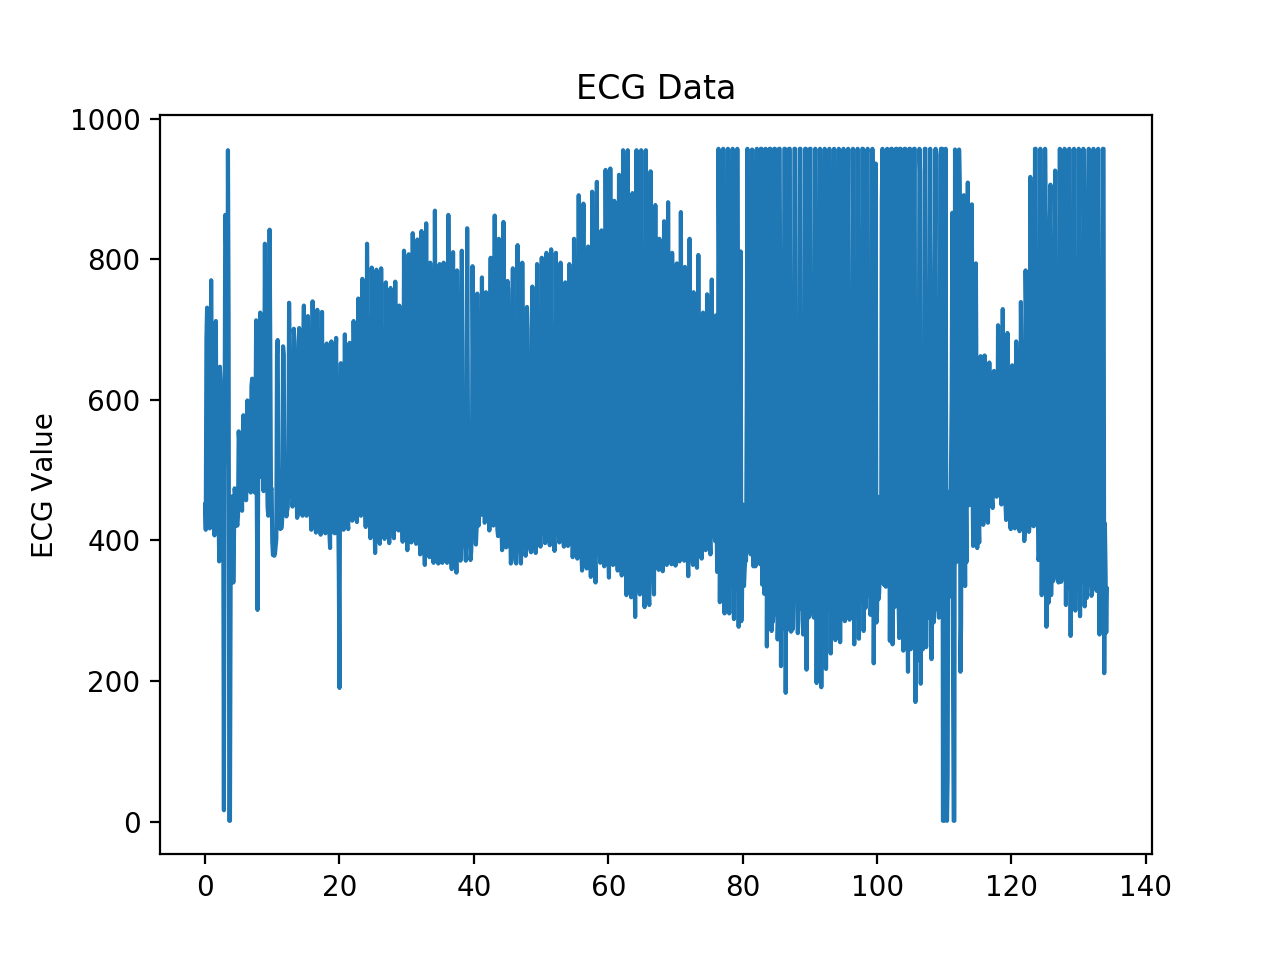

In [80]:
%matplotlib notebook

x = [i*(1.0/dormio_sample_rate) for i in range(0, len(ecg_data))]
plt.plot(x,ecg_data)
plt.ylabel('ECG Value')
plt.title('ECG Data')
plt.show()

<IPython.core.display.Javascript object>


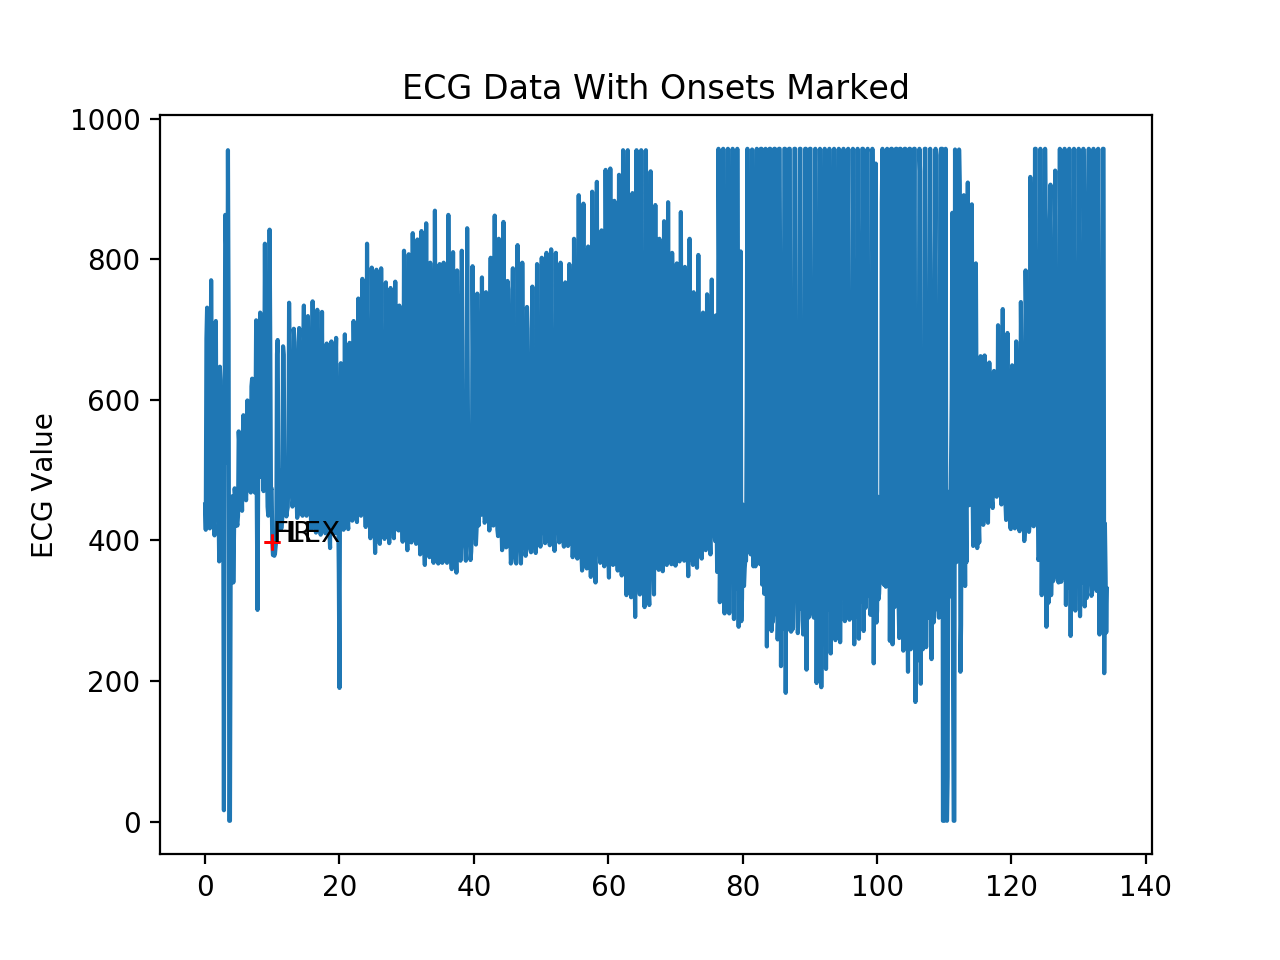

(10, ('FLEX', True)) 100.0
(10, ('HR', True)) 100.0


In [81]:
%matplotlib notebook

plt.plot(x,ecg_data)
plt.ylabel('ECG Value')
plt.title('ECG Data With Onsets Marked')
plot_triggers(plt, session_triggers, ecg_data, dormio_sample_rate)
plt.show()

<IPython.core.display.Javascript object>


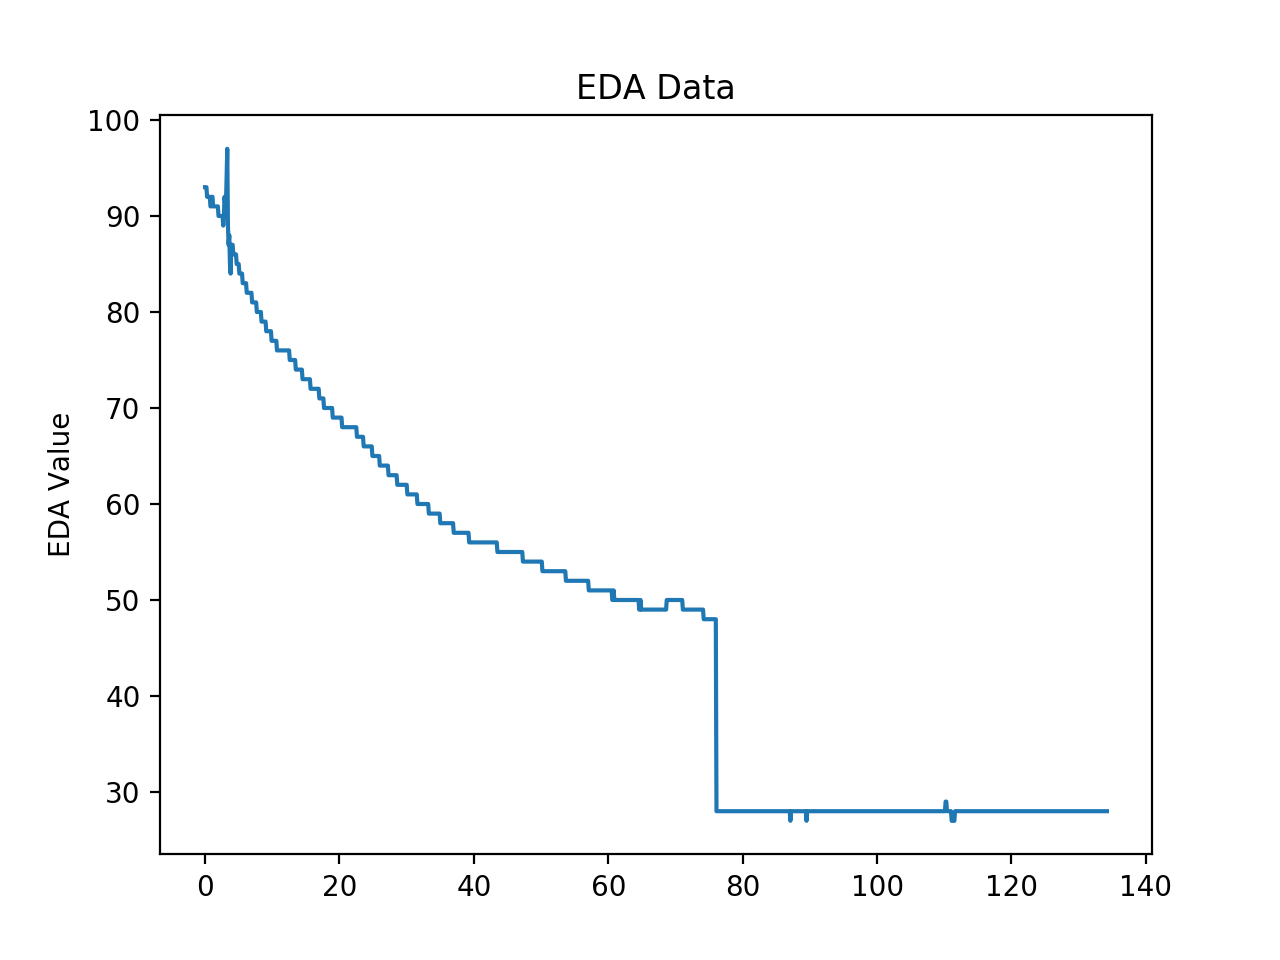

In [82]:
%matplotlib notebook

x = [i*(1.0/dormio_sample_rate) for i in range(0, len(eda_data))]

plt.plot(x,eda_data)
plt.ylabel('EDA Value')
plt.title('EDA Data')
plt.show()

<IPython.core.display.Javascript object>


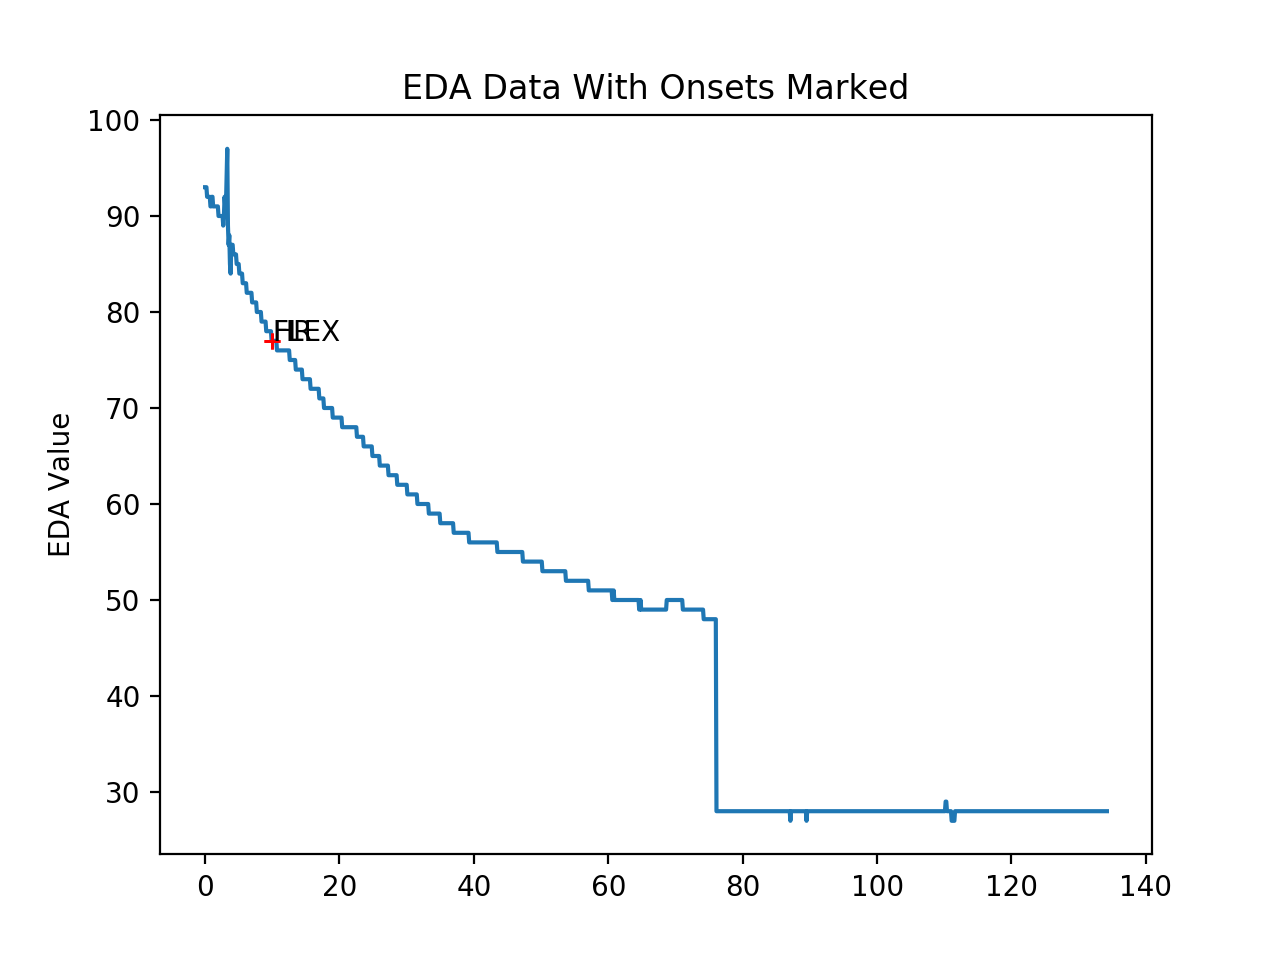

(10, ('FLEX', True)) 100.0
(10, ('HR', True)) 100.0


In [83]:
%matplotlib notebook

plt.plot(x,eda_data)
plt.ylabel('EDA Value')
plt.title('EDA Data With Onsets Marked')
plot_triggers(plt, session_triggers, eda_data, dormio_sample_rate)
plt.show()

<IPython.core.display.Javascript object>


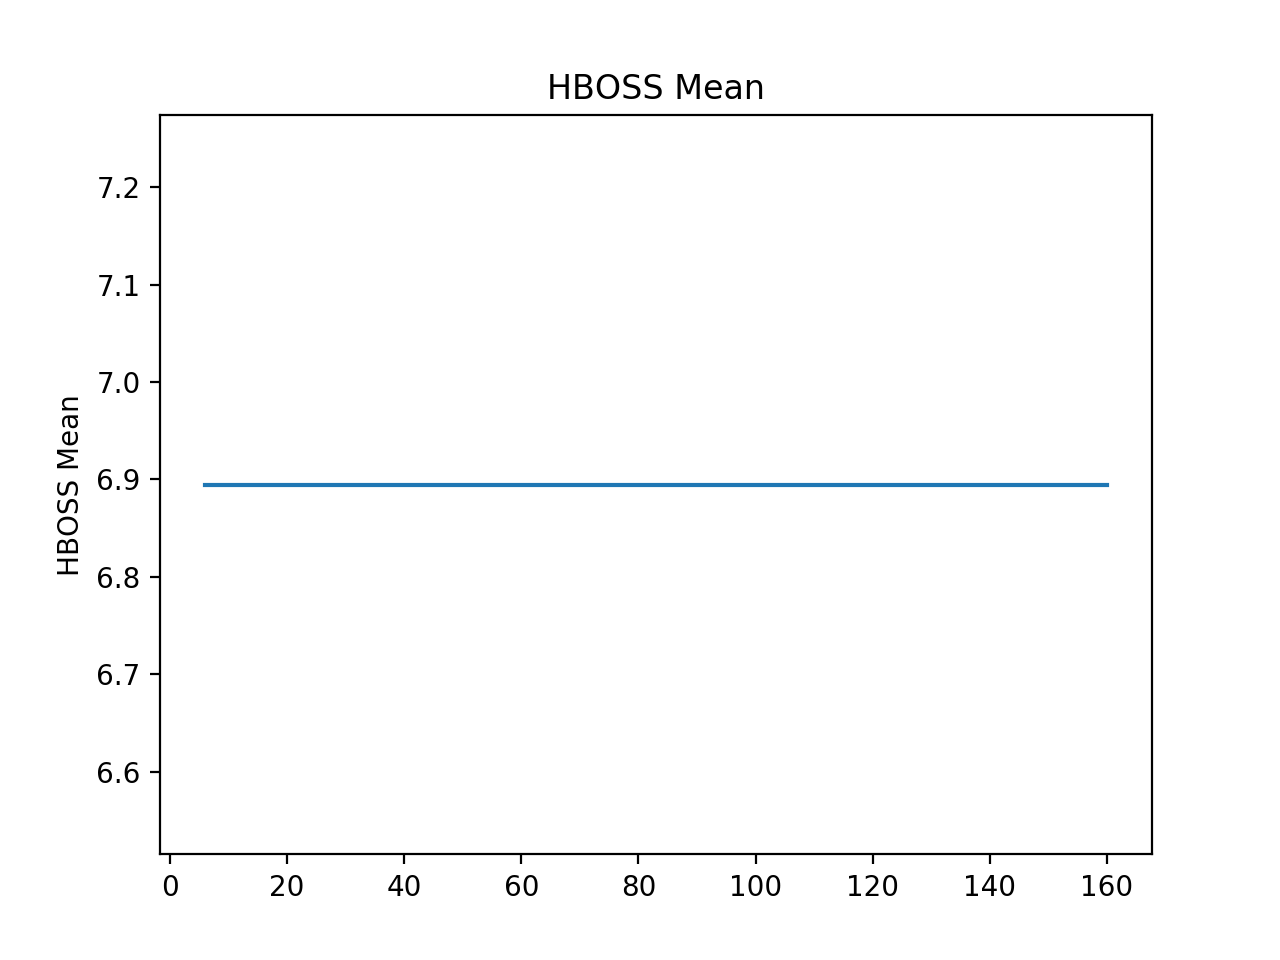

In [84]:
%matplotlib notebook
hboss_mean = [_[0] for _ in hboss]
x_hboss = [_[2] for _ in hboss]
plt.plot(x_hboss, hboss_mean)
plt.ylabel("HBOSS Mean")
plt.title('HBOSS Mean')
plt.show()

<IPython.core.display.Javascript object>


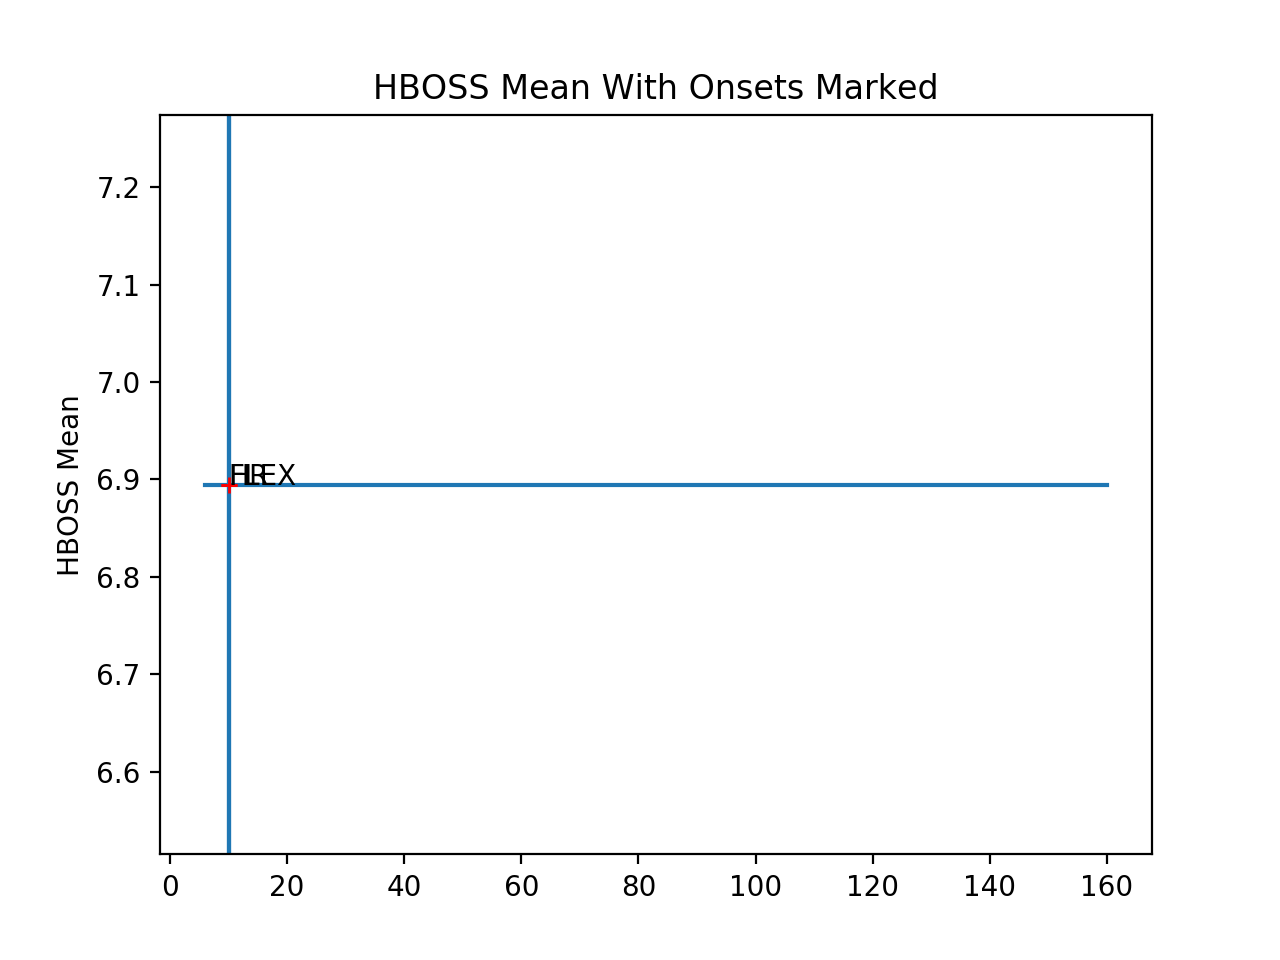

(10, ('FLEX', True)) 100.0
(10, ('HR', True)) 100.0


In [85]:
%matplotlib notebook
plt.plot(x_hboss, hboss_mean)
plt.ylabel("HBOSS Mean")
plt.title('HBOSS Mean With Onsets Marked')
plot_triggers_hboss(plt, session_triggers, hboss_mean, dormio_sample_rate)
plt.show()

<IPython.core.display.Javascript object>


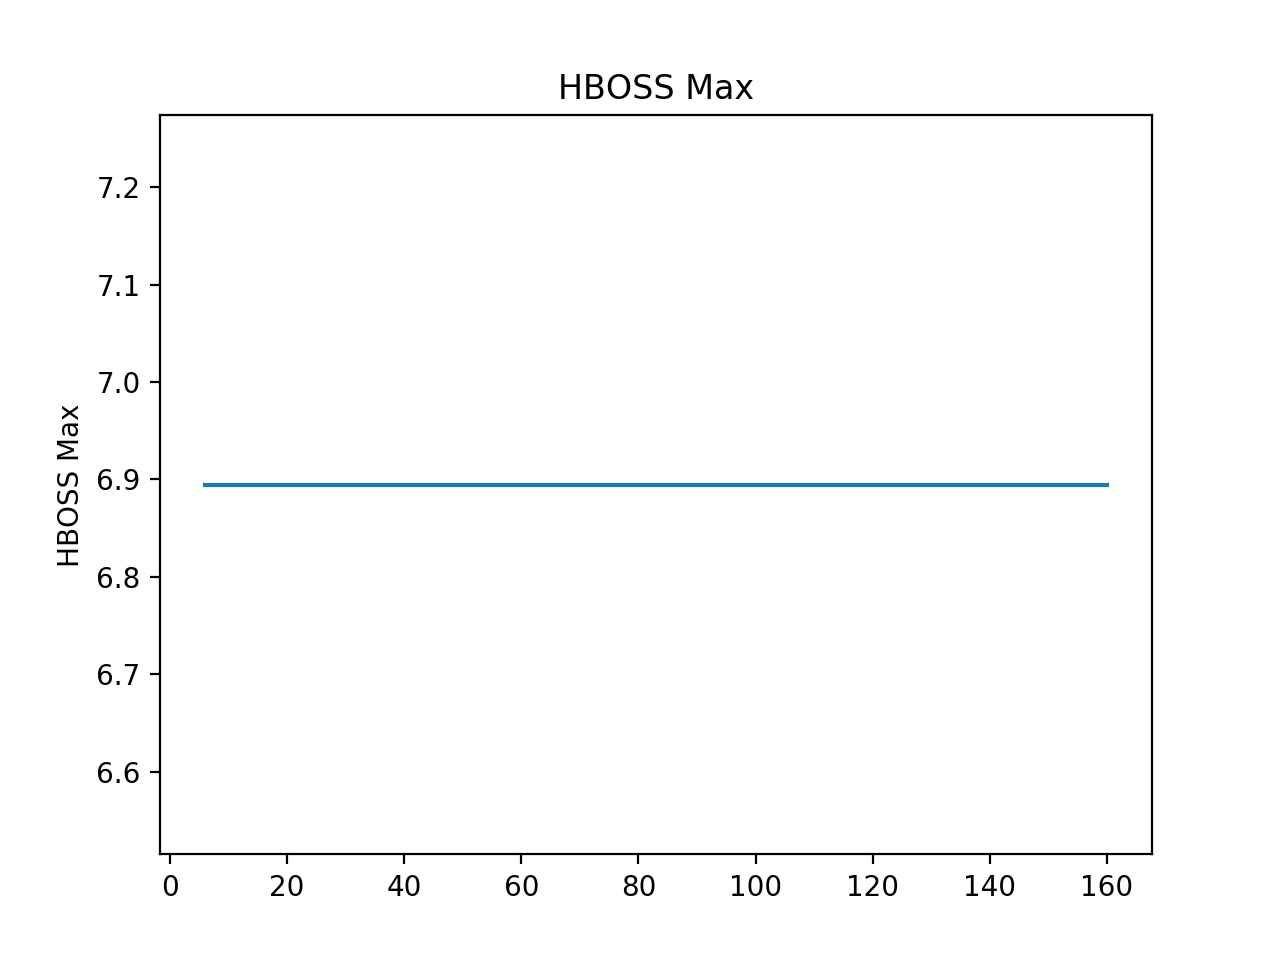

In [86]:
%matplotlib notebook
hboss_max = [_[1] for _ in hboss]
plt.plot(x_hboss, hboss_max)
plt.ylabel("HBOSS Max")
plt.title('HBOSS Max')
plt.show()

<IPython.core.display.Javascript object>


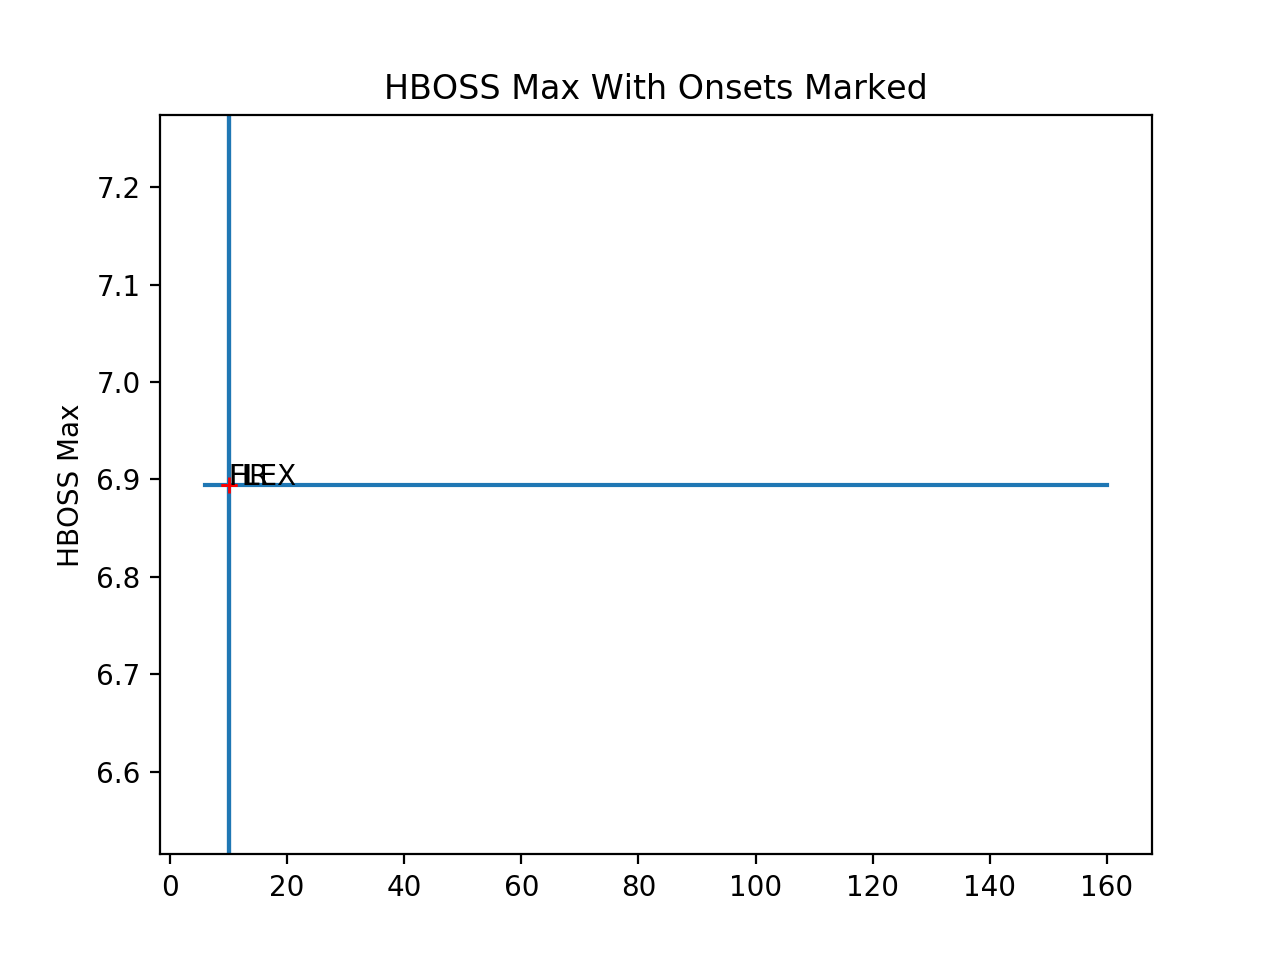

(10, ('FLEX', True)) 100.0
(10, ('HR', True)) 100.0


In [87]:
%matplotlib notebook
plt.plot(x_hboss, hboss_max)
plt.ylabel("HBOSS Max")
plt.title('HBOSS Max With Onsets Marked')
plot_triggers_hboss(plt, session_triggers, hboss_max, dormio_sample_rate)
plt.show()

<IPython.core.display.Javascript object>


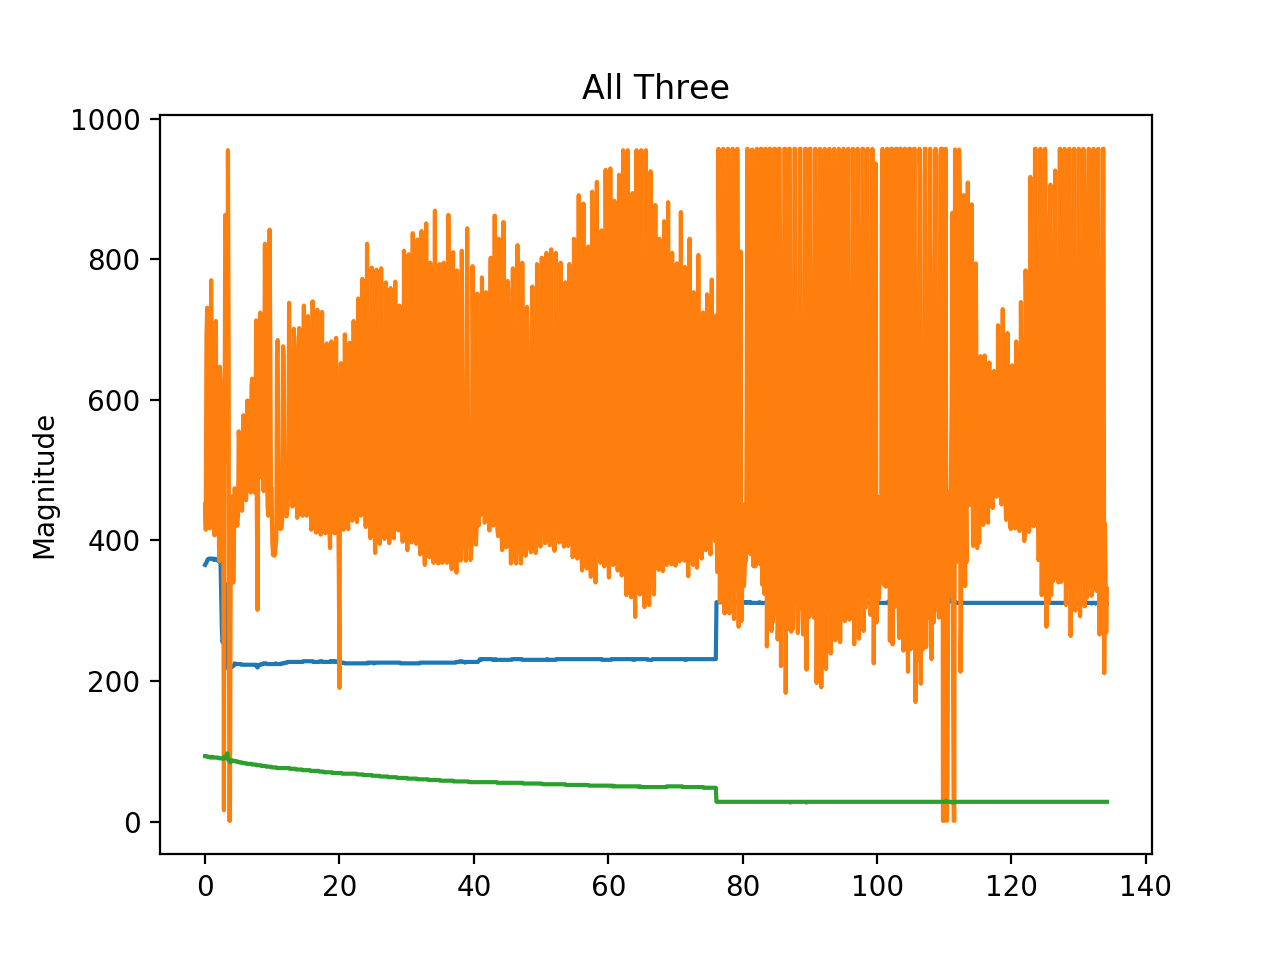

In [88]:
%matplotlib notebook

import matplotlib.pyplot as plt

plt.plot(x,flex_data)
plt.plot(x,ecg_data)
plt.plot(x,eda_data)
plt.ylabel('Magnitude')
plt.title('All Three')
plt.show()